# Medical Image VAE Analysis
## Modular Convolutional Variational Autoencoder for Medical Imaging

This notebook implements a clean, modular approach to training and evaluating Variational Autoencoders on medical imaging datasets using the MedMNIST collection. The code follows proper Python conventions and avoids unnecessary abstraction.

## 1. Libraries and Configuration

In [23]:
# Standard library imports
import os
import random
from typing import Tuple, Dict, List, Any
from pathlib import Path

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
import torchvision.models as models
from tqdm import tqdm

# MedMNIST imports
import medmnist
from medmnist import INFO, Evaluator

print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Initialize VGG for perceptual loss
vgg = models.vgg16(pretrained=True).features[:16] 
for param in vgg.parameters():
    param.requires_grad = False  # only feature extraction
vgg = vgg.eval()

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/
PyTorch version: 2.7.1+cu126
CUDA available: True


/home/gorkem/anaconda3/envs/vae-env/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gorkem/anaconda3/envs/vae-env/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [64]:
# Configuration constants
CONFIG = {
    'DATA_FLAG': 'chestmnist',  # Can change to 'breastmnist', 'pathmnist', etc.
    'BATCH_SIZE': 128,
    'NUM_EPOCHS': 20,
    'LEARNING_RATE': 5e-5,
    'LATENT_DIM': 32,
    'BETA_KL': 1.0,  # KL divergence weighting
    'KL_ANNEAL_EPOCHS': 10,
    'USE_PERCEPTUAL_LOSS': True,  # Enable perceptual loss
    'DISENTANGLEMENT_BETA': 1.31,  # Beta for disentanglement training
    'SEED': 42,
    'SAVE_INTERVAL': 10,  # Save samples every N epochs
    'OUTPUT_DIR': 'outputs'
}

# Set random seeds for reproducibility
def set_seed(seed: int) -> None:
    """Set random seeds for reproducible results."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(CONFIG['SEED'])

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create output directory
output_dir = Path(CONFIG['OUTPUT_DIR'])
output_dir.mkdir(exist_ok=True)
print(f"Output directory: {output_dir.absolute()}")

Using device: cuda
Output directory: /home/gorkem/Desktop/code_files/vae-medical-image-generator/outputs


## 2. Data Preparation and Loading

In [69]:
def get_dataset_info(data_flag: str) -> Dict[str, Any]:
    """Get dataset information and configuration."""
    info = INFO[data_flag]
    dataset_info = {
        'task': info['task'],
        'n_channels': info['n_channels'],
        'n_classes': len(info['label']),
        'data_class': getattr(medmnist, info['python_class']),
        'description': info.get('description', 'No description available')
    }
    return dataset_info

def create_data_loaders(data_flag: str, batch_size: int, download: bool = True) -> Tuple[DataLoader, DataLoader]:
    """Create train and test data loaders."""
    # Get dataset information
    dataset_info = get_dataset_info(data_flag)
    DataClass = dataset_info['data_class']
    
    # Define transforms
    transform = transforms.Compose([
        transforms.ToTensor(),
        # Note: MedMNIST images are already normalized to [0, 1]
    ])
    
    # Load datasets
    train_dataset = DataClass(split='train', transform=transform, download=download)
    test_dataset = DataClass(split='test', transform=transform, download=download)
    
    # Create data loaders
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=torch.cuda.is_available()
    )
    
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=torch.cuda.is_available()
    )
    
    return train_loader, test_loader, dataset_info

# Load data
train_loader, test_loader, dataset_info = create_data_loaders(
    CONFIG['DATA_FLAG'], 
    CONFIG['BATCH_SIZE']
)

print(f"Dataset: {CONFIG['DATA_FLAG']}")
print(f"Task: {dataset_info['task']}")
print(f"Channels: {dataset_info['n_channels']}")
print(f"Classes: {dataset_info['n_classes']}")
print(f"Train samples: {len(train_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")
print(f"Batches per epoch: {len(train_loader)}")

Dataset: chestmnist
Task: multi-label, binary-class
Channels: 1
Classes: 14
Train samples: 78468
Test samples: 22433
Batches per epoch: 614


In [25]:
from torch.utils.data import ConcatDataset

def create_combined_data_loaders(data_flags: List[str], batch_size: int, download: bool = True) -> Tuple[DataLoader, DataLoader, List[Dict[str, Any]]]:
    """Create combined train and test data loaders from multiple MedMNIST datasets."""
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_datasets = []
    test_datasets = []
    dataset_infos = []

    for flag in data_flags:
        dataset_info = get_dataset_info(flag)
        dataset_infos.append(dataset_info)

        DataClass = dataset_info['data_class']
        train_datasets.append(DataClass(split='train', transform=transform, download=download))
        test_datasets.append(DataClass(split='test', transform=transform, download=download))

    combined_train = ConcatDataset(train_datasets)
    combined_test = ConcatDataset(test_datasets)

    train_loader = DataLoader(
        dataset=combined_train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=torch.cuda.is_available()
    )

    test_loader = DataLoader(
        dataset=combined_test,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=torch.cuda.is_available()
    )

    return train_loader, test_loader, dataset_infos


In [68]:
data_flags = ['pathmnist', 'bloodmnist', 'dermamnist']
train_loader, test_loader, dataset_infos = create_combined_data_loaders(data_flags, batch_size=64)

print(f"Loaded {len(dataset_infos)} datasets.")
print(f"Combined train size: {len(train_loader.dataset)}")
print(f"Combined test size: {len(test_loader.dataset)}")


Loaded 3 datasets.
Combined train size: 108962
Combined test size: 12606


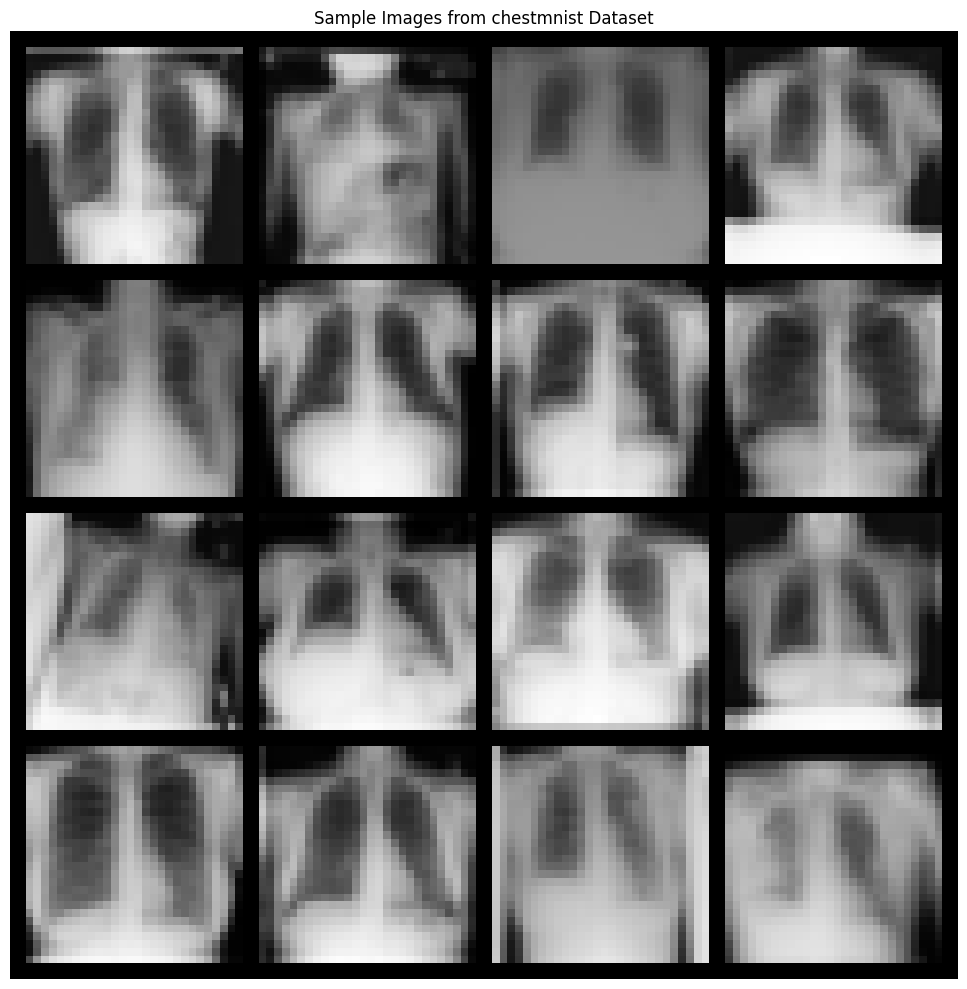

In [70]:
# Visualize sample data
def visualize_samples(data_loader: DataLoader, num_samples: int = 16) -> None:
    """Visualize sample images from the dataset."""
    images, labels = next(iter(data_loader))
    images = images[:num_samples]
    
    # Create grid
    grid = make_grid(images, nrow=4, normalize=True, padding=2)
    
    # Plot
    plt.figure(figsize=(10, 10))
    plt.imshow(grid.permute(1, 2, 0))
    plt.title(f'Sample Images from {CONFIG["DATA_FLAG"]} Dataset')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(train_loader)

## 3. Model Components: Encoder, Decoder, and VAE

In [71]:
class Encoder(nn.Module):
    """Convolutional encoder for VAE."""
    
    def __init__(self, input_channels: int = 3, latent_dim: int = 128):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # Input: 28x28x3 -> 14x14x32
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(num_groups=4, num_channels=32),
            nn.ReLU(inplace=True),
            
            # 14x14x32 -> 7x7x64
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(num_groups=8, num_channels=64),
            nn.ReLU(inplace=True),
        )
        
        # Calculate flattened size
        self.flatten_size = 7 * 7 * 64
        
        # Dense layers
        self.fc_hidden = nn.Linear(self.flatten_size, 1024)
        self.fc_mu = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)
        
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward pass through encoder.
        
        Args:
            x: Input tensor of shape (batch_size, channels, height, width)
            
        Returns:
            Tuple of (mu, logvar) for latent distribution
        """
        # Convolutional layers
        x = self.conv_layers(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Dense layers
        x = F.relu(self.fc_hidden(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        
        return mu, logvar

In [72]:
class Decoder(nn.Module):
    """Convolutional decoder for VAE."""
    
    def __init__(self, latent_dim: int = 128, output_channels: int = 3):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Dense layers
        self.fc = nn.Linear(latent_dim, 7 * 7 * 64)
        
        # Transpose convolutional layers
        self.deconv_layers = nn.Sequential(
            # 7x7x64 -> 14x14x64
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.GroupNorm(num_groups=8, num_channels=64),
            nn.ReLU(inplace=True),
            
            # 14x14x64 -> 28x28x32
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.GroupNorm(num_groups=4, num_channels=32),
            nn.ReLU(inplace=True),
            
            # 28x28x32 -> 28x28x16
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            
            # 28x28x16 -> 28x28x output_channels
            nn.ConvTranspose2d(16, output_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Output values in [0, 1]
        )
        
    def forward(self, z: torch.Tensor) -> torch.Tensor:
        """Forward pass through decoder.
        
        Args:
            z: Latent tensor of shape (batch_size, latent_dim)
            
        Returns:
            Reconstructed image tensor
        """
        # Dense layer
        x = F.relu(self.fc(z))
        
        # Reshape for convolution
        x = x.view(x.size(0), 64, 7, 7)
        
        # Transpose convolutional layers
        x = self.deconv_layers(x)
        
        return x

In [73]:
def reparameterize(mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
    """Reparameterization trick for VAE sampling."""
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

class PerceptualLoss(nn.Module):
    """Perceptual loss using VGG features."""
    
    def __init__(self):
        super(PerceptualLoss, self).__init__()
        self.vgg = vgg.to(device)
        self.criterion = nn.MSELoss()

    def forward(self, x: torch.Tensor, x_hat: torch.Tensor) -> torch.Tensor:
        """Calculate perceptual loss between original and reconstructed images."""
        # Convert grayscale to RGB if needed
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
            x_hat = x_hat.repeat(1, 3, 1, 1)

        # Normalize for VGG
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
        x = normalize(x)
        x_hat = normalize(x_hat)

        # Extract features
        f_x = self.vgg(x)
        f_x_hat = self.vgg(x_hat)

        return self.criterion(f_x, f_x_hat)

def vae_loss(recon_x: torch.Tensor, x: torch.Tensor, mu: torch.Tensor, 
             logvar: torch.Tensor, beta: float = 1.0, 
             use_perceptual_loss: bool = False, 
             perceptual_loss_fn: PerceptualLoss = None) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """Calculate VAE loss (reconstruction + KL divergence).
    
    Args:
        recon_x: Reconstructed images
        x: Original images
        mu: Mean of latent distribution
        logvar: Log variance of latent distribution
        beta: KL divergence weighting factor
        use_perceptual_loss: Whether to use perceptual loss instead of BCE
        perceptual_loss_fn: Perceptual loss function instance
        
    Returns:
        Tuple of (total_loss, reconstruction_loss, kl_loss)
    """
    if use_perceptual_loss and perceptual_loss_fn is not None:
        # Use perceptual loss as reconstruction loss
        recon_loss = perceptual_loss_fn(x, recon_x)
    else:
        # Use binary cross-entropy as reconstruction loss
        recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss
    total_loss = recon_loss + beta * kl_loss
    
    return total_loss, recon_loss, kl_loss

class VAE(nn.Module):
    """Variational Autoencoder combining encoder and decoder."""
    
    def __init__(self, input_channels: int = 3, latent_dim: int = 128, 
                 use_perceptual_loss: bool = False):
        super().__init__()
        self.latent_dim = latent_dim
        self.use_perceptual_loss = use_perceptual_loss
        self.encoder = Encoder(input_channels, latent_dim)
        self.decoder = Decoder(latent_dim, input_channels)
        
        # Initialize perceptual loss if needed
        if self.use_perceptual_loss:
            self.perceptual_loss = PerceptualLoss()
        else:
            self.perceptual_loss = None
        
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Forward pass through VAE.
        
        Args:
            x: Input images
            
        Returns:
            Tuple of (reconstructed_images, mu, logvar)
        """
        # Encode
        mu, logvar = self.encoder(x)
        
        # Sample from latent distribution
        z = reparameterize(mu, logvar)
        
        # Decode
        recon_x = self.decoder(z)
        
        return recon_x, mu, logvar
    
    def calculate_loss(self, data: torch.Tensor, reconstruction: torch.Tensor, 
                      z_mean: torch.Tensor, z_log_var: torch.Tensor, 
                      beta: float = 1.0) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Calculate VAE loss using the same approach as ConvolutionalVariationalEncoder."""
        if self.use_perceptual_loss:
            # Use perceptual loss as the distortion loss term
            distortion_loss = self.perceptual_loss(data, reconstruction)
        else:
            # Use MSE loss as the distortion loss term (following ConvolutionalVariationalEncoder)
            distortion_loss = F.mse_loss(reconstruction, data, reduction='none')
            distortion_loss = torch.sum(distortion_loss, dim=(1, 2, 3))  # Sum over H, W, C
            distortion_loss = torch.mean(distortion_loss)  # Mean over batch

        # KL Divergence Loss (same as ConvolutionalVariationalEncoder)
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp(), dim=1)
        kl_loss = torch.mean(kl_loss)

        total_loss = distortion_loss + beta * kl_loss
        return total_loss, distortion_loss, kl_loss
    
    def generate(self, num_samples: int, device: torch.device) -> torch.Tensor:
        """Generate new samples from random latent codes."""
        with torch.no_grad():
            z = torch.randn(num_samples, self.latent_dim, device=device)
            samples = self.decoder(z)
        return samples

In [74]:
# Initialize model
model = VAE(
    input_channels=dataset_info['n_channels'],
    latent_dim=CONFIG['LATENT_DIM'],
    use_perceptual_loss=CONFIG['USE_PERCEPTUAL_LOSS']
).to(device)

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=CONFIG['LEARNING_RATE'])

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model initialized with {total_params:,} total parameters")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / 1024 / 1024:.2f} MB (float32)")
print(f"Using perceptual loss: {CONFIG['USE_PERCEPTUAL_LOSS']}")

Model initialized with 5,196,225 total parameters
Trainable parameters: 3,460,737
Model size: 19.82 MB (float32)
Using perceptual loss: True


## 4. Training Loop

In [75]:
def train_epoch(model: VAE, train_loader: DataLoader, optimizer: optim.Optimizer,
                device: torch.device, beta: float) -> Dict[str, float]:
    """Train model for one epoch."""
    model.train()
    total_loss = 0.0
    total_recon_loss = 0.0
    total_kl_loss = 0.0
    num_batches = len(train_loader)
    
    with tqdm(train_loader, desc="Training", leave=False) as pbar:
        for batch_idx, (data, _) in enumerate(pbar):
            data = data.to(device)
            
            # Forward pass
            recon_batch, mu, logvar = model(data)
            
            # Calculate loss using the model's calculate_loss method (same as ConvolutionalVariationalEncoder)
            loss, recon_loss, kl_loss = model.calculate_loss(data, recon_batch, mu, logvar, beta)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Accumulate losses
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Recon': f'{recon_loss.item():.4f}',
                'KL': f'{kl_loss.item():.4f}'
            })
    
    return {
        'total_loss': total_loss / num_batches,
        'recon_loss': total_recon_loss / num_batches,
        'kl_loss': total_kl_loss / num_batches
    }

def evaluate_model(model: VAE, test_loader: DataLoader, 
                  device: torch.device, beta: float) -> Dict[str, float]:
    """Evaluate model on test set."""
    model.eval()
    total_loss = 0.0
    total_recon_loss = 0.0
    total_kl_loss = 0.0
    num_batches = len(test_loader)
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            
            # Forward pass
            recon_batch, mu, logvar = model(data)
            
            # Calculate loss using the model's calculate_loss method (same as ConvolutionalVariationalEncoder)
            loss, recon_loss, kl_loss = model.calculate_loss(data, recon_batch, mu, logvar, beta)
            
            # Accumulate losses
            total_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
    
    return {
        'total_loss': total_loss / num_batches,
        'recon_loss': total_recon_loss / num_batches,
        'kl_loss': total_kl_loss / num_batches
    }

In [76]:
# Training loop
train_losses = []
test_losses = []

print("Starting training...")
print(f"Total epochs: {CONFIG['NUM_EPOCHS']}")
print(f"KL annealing over {CONFIG['KL_ANNEAL_EPOCHS']} epochs")
print(f"Using perceptual loss: {CONFIG['USE_PERCEPTUAL_LOSS']}")

# KL annealing configuration (following ConvolutionalVariationalEncoder approach)
kl_anneal_epochs = 200  # Extended annealing period like in ConvolutionalVariationalEncoder

for epoch in range(CONFIG['NUM_EPOCHS']):
    # Calculate beta for KL annealing (following ConvolutionalVariationalEncoder approach)
    beta = min(CONFIG['BETA_KL'], (epoch + 1) / kl_anneal_epochs)

    # Train for one epoch
    train_metrics = train_epoch(model, train_loader, optimizer, device, beta)
    
    # Evaluate on test set
    test_metrics = evaluate_model(model, test_loader, device, beta)
    
    # Store losses
    train_losses.append(train_metrics)
    test_losses.append(test_metrics)
    
    # Print epoch summary
    print(f"Epoch [{epoch+1}/{CONFIG['NUM_EPOCHS']}] β={beta:.3f}")
    print(f"  Train - Loss: {train_metrics['total_loss']:.4f}, "
          f"Recon: {train_metrics['recon_loss']:.4f}, "
          f"KL: {train_metrics['kl_loss']:.4f}")
    print(f"  Test  - Loss: {test_metrics['total_loss']:.4f}, "
          f"Recon: {test_metrics['recon_loss']:.4f}, "
          f"KL: {test_metrics['kl_loss']:.4f}")
    
    # Save samples periodically
    if (epoch + 1) % CONFIG['SAVE_INTERVAL'] == 0:
        with torch.no_grad():
            # Generate new samples
            samples = model.generate(16, device)
            save_image(samples, output_dir / f'generated_epoch_{epoch+1}.png', 
                      nrow=4, normalize=True)
            
            # Reconstruct test images
            test_data, _ = next(iter(test_loader))
            test_data = test_data[:16].to(device)
            recon_data, _, _ = model(test_data)
            
            # Save comparison
            comparison = torch.cat([test_data, recon_data])
            save_image(comparison, output_dir / f'reconstruction_epoch_{epoch+1}.png',
                      nrow=8, normalize=True)
        
        print(f"  Saved samples to {output_dir}")

print("Training completed!")

Starting training...
Total epochs: 20
KL annealing over 10 epochs
Using perceptual loss: True


Epoch [1/20] β=0.005
  Train - Loss: 13.3531, Recon: 12.7871, KL: 113.1892
  Test  - Loss: 10.4197, Recon: 9.8152, KL: 120.8902


Epoch [2/20] β=0.010
  Train - Loss: 9.9964, Recon: 8.9394, KL: 105.6986
  Test  - Loss: 9.5113, Recon: 8.4853, KL: 102.6027


Epoch [3/20] β=0.015
  Train - Loss: 9.1823, Recon: 7.7730, KL: 93.9559
  Test  - Loss: 8.6929, Recon: 7.3092, KL: 92.2497


Epoch [4/20] β=0.020
  Train - Loss: 8.6965, Recon: 6.9886, KL: 85.3955
  Test  - Loss: 8.3685, Recon: 6.6911, KL: 83.8707


Epoch [5/20] β=0.025
  Train - Loss: 8.4330, Recon: 6.4988, KL: 77.3682
  Test  - Loss: 8.1929, Recon: 6.3042, KL: 75.5497


Epoch [6/20] β=0.030
  Train - Loss: 8.2689, Recon: 6.1809, KL: 69.6021
  Test  - Loss: 8.0471, Recon: 6.0125, KL: 67.8185


Epoch [7/20] β=0.035
  Train - Loss: 8.1587, Recon: 5.9762, KL: 62.3565
  Test  - Loss: 7.9652, Recon: 5.8681, KL: 59.9161


Epoch [8/20] β=0.040
  Train - Loss: 8.0741, Recon: 5.8423, KL: 55.7956
  Test  - Loss: 7.8988, Recon: 5.7372, KL: 54.0404


Epoch [9/20] β=0.045
  Train - Loss: 8.0101, Recon: 5.7577, KL: 50.0539
  Test  - Loss: 7.8758, Recon: 5.6723, KL: 48.9667


Epoch [10/20] β=0.050
  Train - Loss: 7.9624, Recon: 5.6979, KL: 45.2898
  Test  - Loss: 7.8493, Recon: 5.6340, KL: 44.3070
  Saved samples to outputs


Epoch [11/20] β=0.055
  Train - Loss: 7.9386, Recon: 5.6605, KL: 41.4186
  Test  - Loss: 7.8653, Recon: 5.6582, KL: 40.1294


Epoch [12/20] β=0.060
  Train - Loss: 7.9307, Recon: 5.6375, KL: 38.2202
  Test  - Loss: 7.8420, Recon: 5.6332, KL: 36.8136


Epoch [13/20] β=0.065
  Train - Loss: 7.9347, Recon: 5.6183, KL: 35.6377
  Test  - Loss: 7.8787, Recon: 5.5577, KL: 35.7086


Epoch [14/20] β=0.070
  Train - Loss: 7.9528, Recon: 5.6136, KL: 33.4168
  Test  - Loss: 7.9041, Recon: 5.5839, KL: 33.1459


Epoch [15/20] β=0.075
  Train - Loss: 7.9788, Recon: 5.6154, KL: 31.5125
  Test  - Loss: 7.9280, Recon: 5.5914, KL: 31.1539


Epoch [16/20] β=0.080
  Train - Loss: 8.0201, Recon: 5.6266, KL: 29.9179
  Test  - Loss: 7.9727, Recon: 5.5735, KL: 29.9902


Epoch [17/20] β=0.085
  Train - Loss: 8.0587, Recon: 5.6392, KL: 28.4639
  Test  - Loss: 8.0295, Recon: 5.5949, KL: 28.6421


Epoch [18/20] β=0.090
  Train - Loss: 8.0992, Recon: 5.6544, KL: 27.1650
  Test  - Loss: 8.0780, Recon: 5.6771, KL: 26.6772


Epoch [19/20] β=0.095
  Train - Loss: 8.1497, Recon: 5.6822, KL: 25.9740
  Test  - Loss: 8.1402, Recon: 5.6508, KL: 26.2045


Epoch [20/20] β=0.100
  Train - Loss: 8.1971, Recon: 5.7092, KL: 24.8789
  Test  - Loss: 8.1873, Recon: 5.7445, KL: 24.4283
  Saved samples to outputs
Training completed!


## 4.5. Disentanglement Training

The disentanglement training uses a higher beta value to encourage better separation of latent factors, following the approach from ConvolutionalVariationalEncoder.

In [77]:
# Initialize disentanglement model with same architecture but fresh parameters
disentanglement_model = VAE(
    input_channels=dataset_info['n_channels'],
    latent_dim=CONFIG['LATENT_DIM'],
    use_perceptual_loss=CONFIG['USE_PERCEPTUAL_LOSS']
).to(device)

disentanglement_optimizer = optim.Adam(disentanglement_model.parameters(), lr=CONFIG['LEARNING_RATE'] / 4)

# Disentanglement training with high beta (following ConvolutionalVariationalEncoder)
disentanglement_losses = []
beta_disentanglement = CONFIG['DISENTANGLEMENT_BETA']  # High beta for disentanglement

def disentanglement_func(epoch_num):
    return 2 * ((epoch_num / 20) ** (1.8))

print(f"\nStarting disentanglement training with β={beta_disentanglement}")
print(f"Epochs: {CONFIG['NUM_EPOCHS']}")

for epoch in range(CONFIG['NUM_EPOCHS']):
    # Use fixed high beta for disentanglement (no annealing)
    beta = disentanglement_func(epoch)
    train_metrics = train_epoch(disentanglement_model, train_loader, disentanglement_optimizer, 
                               device, beta)
    
    # Store losses
    disentanglement_losses.append(train_metrics)
    
    # Print epoch summary
    print(f"Disentanglement Epoch [{epoch+1}/{CONFIG['NUM_EPOCHS']}] β={beta}")
    print(f"  Train - Loss: {train_metrics['total_loss']:.4f}, "
          f"Recon: {train_metrics['recon_loss']:.4f}, "
          f"KL: {train_metrics['kl_loss']:.4f}")
    
    # Save samples periodically
    if (epoch + 1) % CONFIG['SAVE_INTERVAL'] == 0:
        with torch.no_grad():
            # Generate new samples
            samples = disentanglement_model.generate(16, device)
            save_image(samples, output_dir / f'disentangled_generated_epoch_{epoch+1}.png', 
                      nrow=4, normalize=True)
            
            # Reconstruct test images
            test_data, _ = next(iter(test_loader))
            test_data = test_data[:16].to(device)
            recon_data, _, _ = disentanglement_model(test_data)
            
            # Save comparison
            comparison = torch.cat([test_data, recon_data])
            save_image(comparison, output_dir / f'disentangled_reconstruction_epoch_{epoch+1}.png',
                      nrow=8, normalize=True)
        
        print(f"  Saved disentanglement samples to {output_dir}")

print("Disentanglement training completed!")


Starting disentanglement training with β=1.31
Epochs: 20


Disentanglement Epoch [1/20] β=0.0
  Train - Loss: 14.9287, Recon: 14.9287, KL: 251.9144


Disentanglement Epoch [2/20] β=0.009102821015130401
  Train - Loss: 11.2947, Recon: 10.2191, KL: 118.1627


Disentanglement Epoch [3/20] β=0.03169786384922227
  Train - Loss: 12.3277, Recon: 9.7325, KL: 81.8725


Disentanglement Epoch [4/20] β=0.06576491482298663
  Train - Loss: 13.6662, Recon: 9.8852, KL: 57.4921


Disentanglement Epoch [5/20] β=0.11037837291689719
  Train - Loss: 14.3992, Recon: 10.4079, KL: 36.1606


Disentanglement Epoch [6/20] β=0.16493848884661177
  Train - Loss: 14.4832, Recon: 10.8994, KL: 21.7276


Disentanglement Epoch [7/20] β=0.22900673457709056
  Train - Loss: 14.3758, Recon: 11.1831, KL: 13.9416


Disentanglement Epoch [8/20] β=0.30224037226659656
  Train - Loss: 14.3085, Recon: 11.4079, KL: 9.5969


Disentanglement Epoch [9/20] β=0.384359818874058
  Train - Loss: 14.2658, Recon: 11.6308, KL: 6.8556


Disentanglement Epoch [10/20] β=0.4751300739062956
  Train - Loss: 14.2615, Recon: 11.8491, KL: 5.0773


  Saved disentanglement samples to outputs


Disentanglement Epoch [11/20] β=0.5743491774985174
  Train - Loss: 14.2452, Recon: 12.0485, KL: 3.8246


Disentanglement Epoch [12/20] β=0.6818405672692449
  Train - Loss: 14.2337, Recon: 12.2339, KL: 2.9329


Disentanglement Epoch [13/20] β=0.7974477671387687
  Train - Loss: 14.1865, Recon: 12.3904, KL: 2.2522


Disentanglement Epoch [14/20] β=0.9210305540558519
  Train - Loss: 14.1147, Recon: 12.5182, KL: 1.7335


Disentanglement Epoch [15/20] β=1.0524621053100636
  Train - Loss: 14.0435, Recon: 12.6392, KL: 1.3343


Disentanglement Epoch [16/20] β=1.1916268211799137
  Train - Loss: 13.9317, Recon: 12.7219, KL: 1.0152


Disentanglement Epoch [17/20] β=1.33841862731683
  Train - Loss: 13.8139, Recon: 12.7925, KL: 0.7631


Disentanglement Epoch [18/20] β=1.492739626944632
  Train - Loss: 13.6288, Recon: 12.8000, KL: 0.5553


Disentanglement Epoch [19/20] β=1.6544990139122189
  Train - Loss: 13.4702, Recon: 12.8180, KL: 0.3942


Disentanglement Epoch [20/20] β=1.8236121840688744
  Train - Loss: 13.2676, Recon: 12.7790, KL: 0.2679


  Saved disentanglement samples to outputs
Disentanglement training completed!


## 5. Evaluation and Visualization

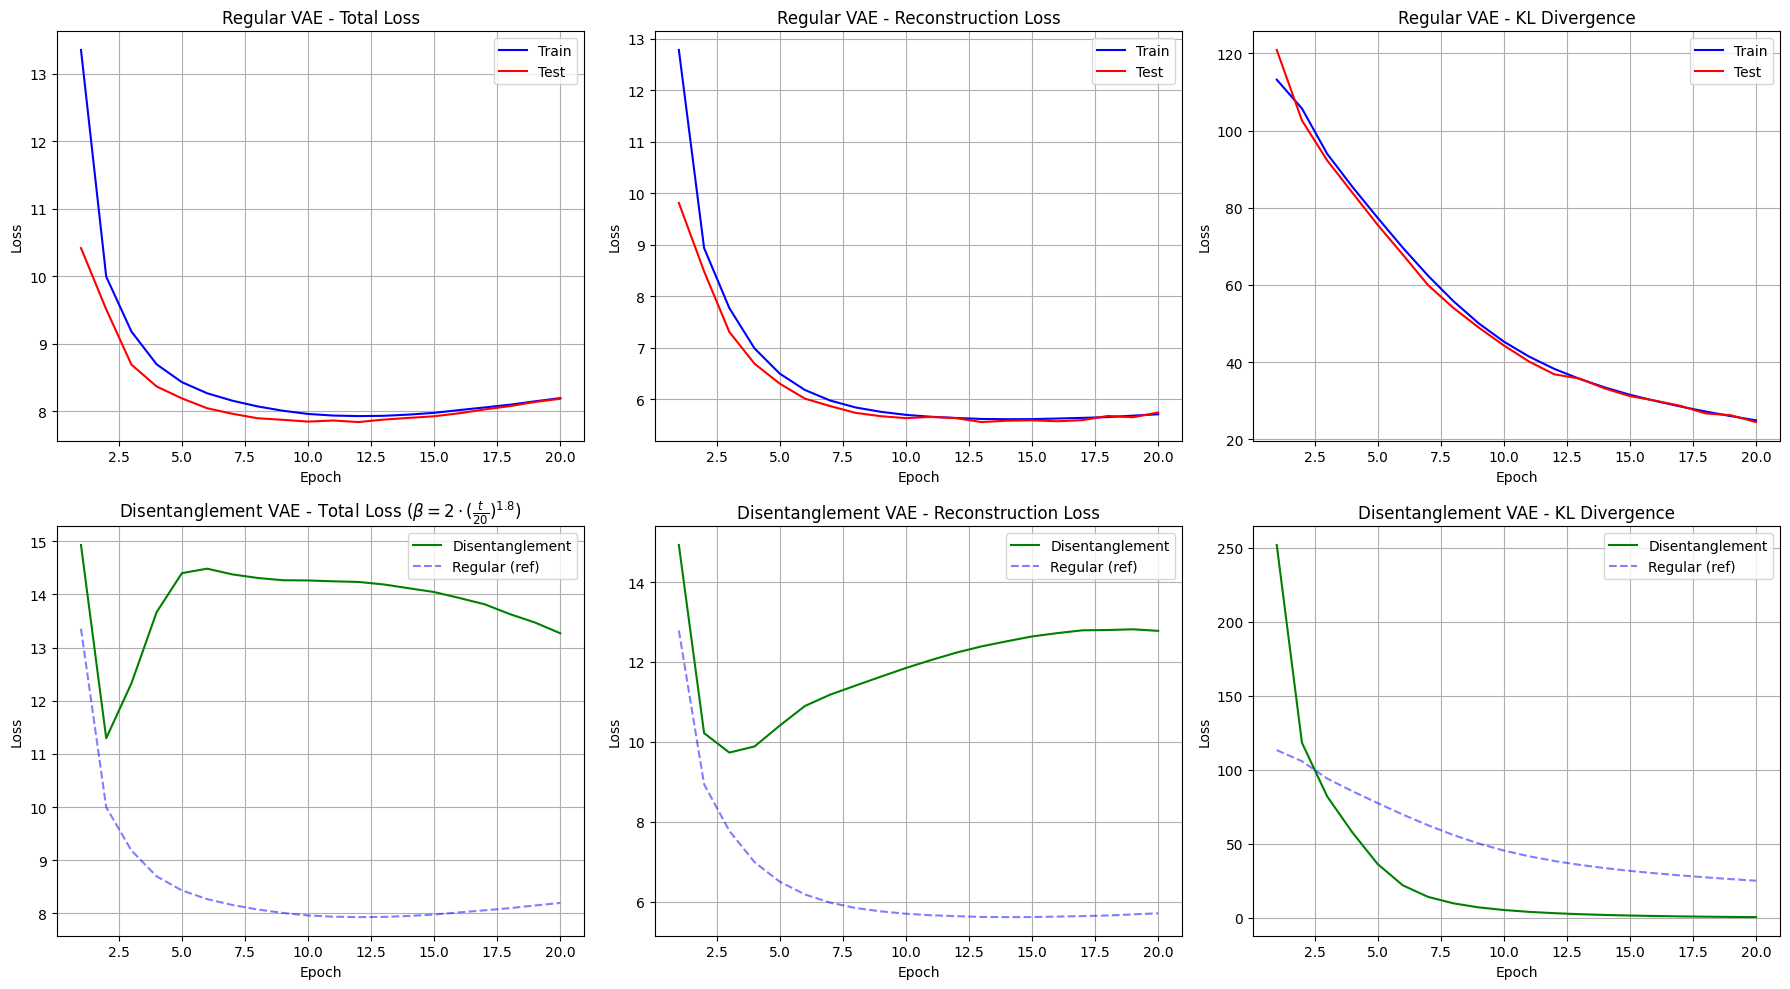

In [85]:
# Plot training curves
def plot_training_curves(train_losses: list, test_losses: list, 
                        disentanglement_losses: list = None) -> None:
    """Plot training and test loss curves, with optional disentanglement comparison."""
    epochs = range(1, len(train_losses) + 1)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Regular VAE curves (top row)
    # Total loss
    axes[0,0].plot(epochs, [m['total_loss'] for m in train_losses], 'b-', label='Train')
    axes[0,0].plot(epochs, [m['total_loss'] for m in test_losses], 'r-', label='Test')
    axes[0,0].set_title('Regular VAE - Total Loss')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True)
    
    # Reconstruction loss
    axes[0,1].plot(epochs, [m['recon_loss'] for m in train_losses], 'b-', label='Train')
    axes[0,1].plot(epochs, [m['recon_loss'] for m in test_losses], 'r-', label='Test')
    axes[0,1].set_title('Regular VAE - Reconstruction Loss')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].legend()
    axes[0,1].grid(True)
    
    # KL divergence
    axes[0,2].plot(epochs, [m['kl_loss'] for m in train_losses], 'b-', label='Train')
    axes[0,2].plot(epochs, [m['kl_loss'] for m in test_losses], 'r-', label='Test')
    axes[0,2].set_title('Regular VAE - KL Divergence')
    axes[0,2].set_xlabel('Epoch')
    axes[0,2].set_ylabel('Loss')
    axes[0,2].legend()
    axes[0,2].grid(True)
    
    # Disentanglement VAE curves (bottom row)
    if disentanglement_losses is not None:
        disentanglement_epochs = range(1, len(disentanglement_losses) + 1)
        
        # Total loss
        axes[1,0].plot(disentanglement_epochs, [m['total_loss'] for m in disentanglement_losses], 'g-', label='Disentanglement')
        axes[1,0].plot(epochs, [m['total_loss'] for m in train_losses], 'b--', alpha=0.5, label='Regular (ref)')
        axes[1,0].set_title(r'Disentanglement VAE - Total Loss ($\beta = 2 \cdot (\frac{t}{20})^{1.8}$)')
        axes[1,0].set_xlabel('Epoch')
        axes[1,0].set_ylabel('Loss')
        axes[1,0].legend()
        axes[1,0].grid(True)
        
        # Reconstruction loss
        axes[1,1].plot(disentanglement_epochs, [m['recon_loss'] for m in disentanglement_losses], 'g-', label='Disentanglement')
        axes[1,1].plot(epochs, [m['recon_loss'] for m in train_losses], 'b--', alpha=0.5, label='Regular (ref)')
        axes[1,1].set_title('Disentanglement VAE - Reconstruction Loss')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].set_ylabel('Loss')
        axes[1,1].legend()
        axes[1,1].grid(True)
        
        # KL divergence
        axes[1,2].plot(disentanglement_epochs, [m['kl_loss'] for m in disentanglement_losses], 'g-', label='Disentanglement')
        axes[1,2].plot(epochs, [m['kl_loss'] for m in train_losses], 'b--', alpha=0.5, label='Regular (ref)')
        axes[1,2].set_title('Disentanglement VAE - KL Divergence')
        axes[1,2].set_xlabel('Epoch')
        axes[1,2].set_ylabel('Loss')
        axes[1,2].legend()
        axes[1,2].grid(True)
    else:
        # Hide bottom row if no disentanglement data
        for ax in axes[1,:]:
            ax.set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Plot the curves
plot_training_curves(train_losses, test_losses, disentanglement_losses)

Regular VAE Results:
Reconstruction comparison:


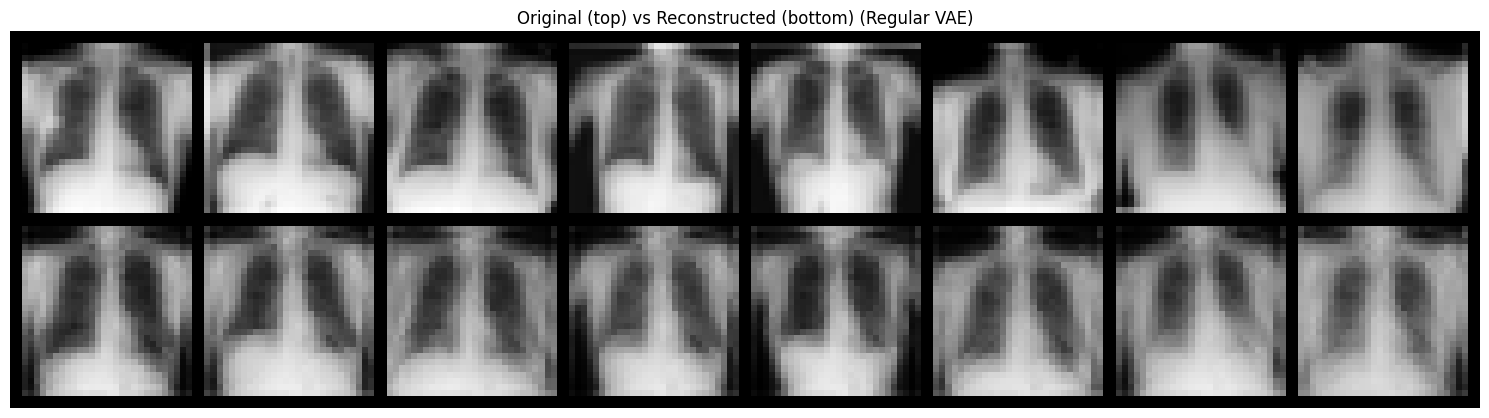


Generated samples:


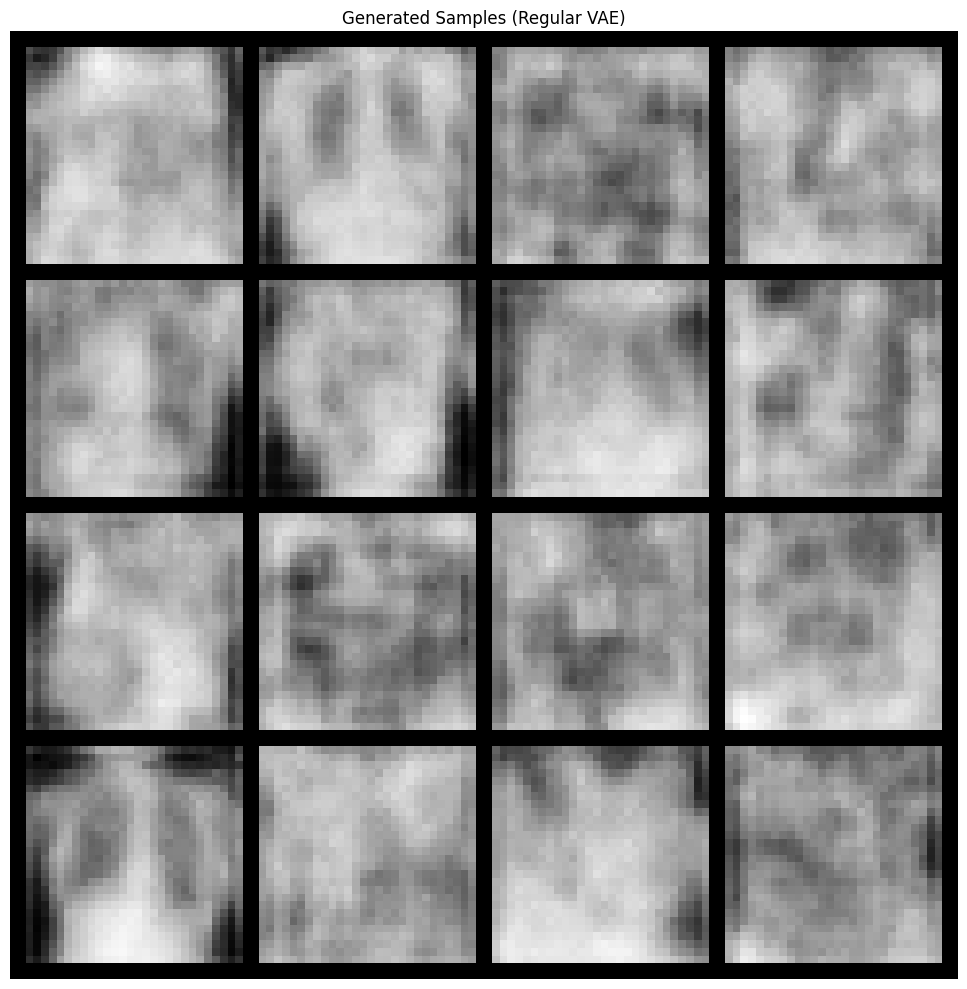


Latent space interpolation:


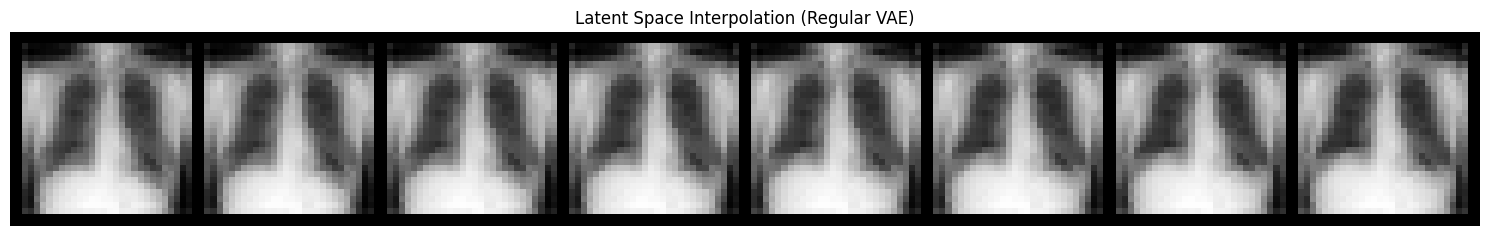


Disentanglement VAE Results:
Reconstruction comparison:


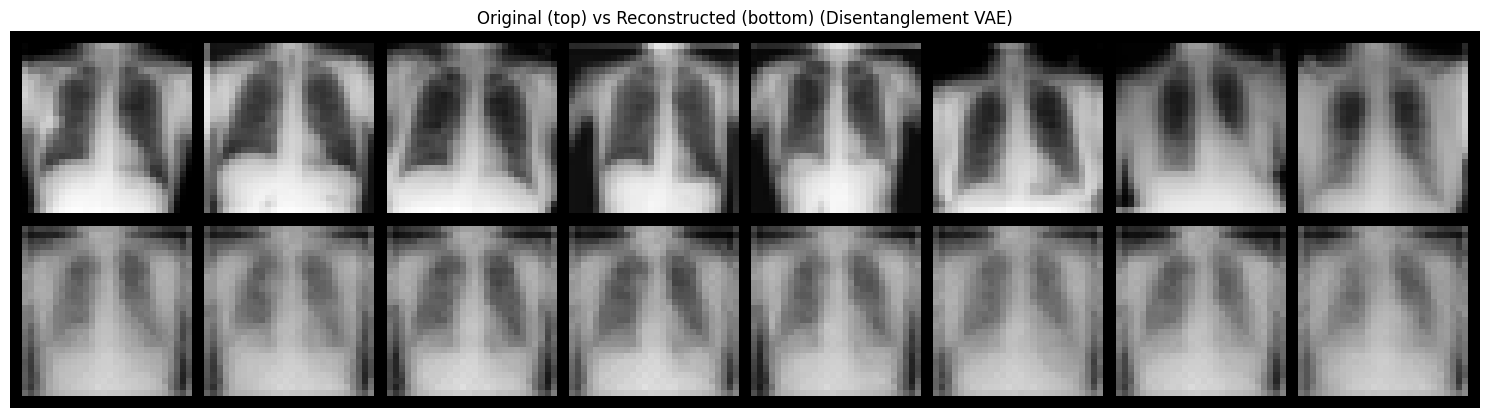


Generated samples:


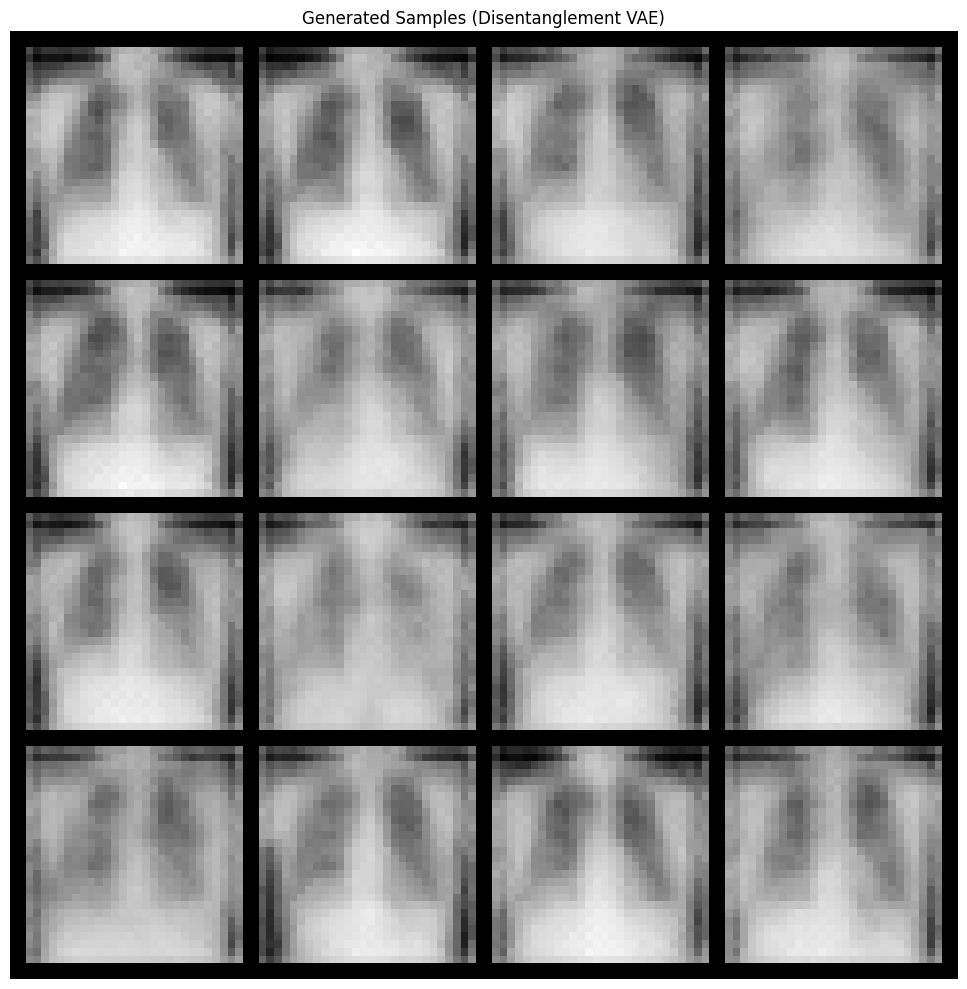


Latent space interpolation:


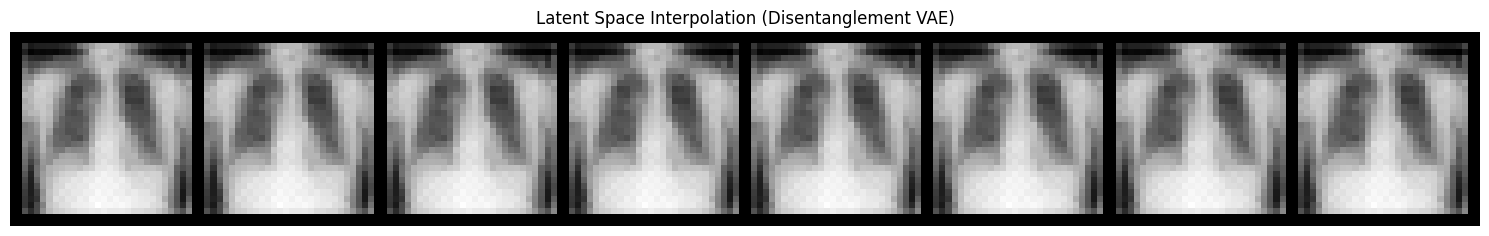

In [79]:
# Visualization functions
def show_reconstruction_comparison(model: VAE, test_loader: DataLoader, 
                                 device: torch.device, num_samples: int = 8, 
                                 title_suffix: str = "") -> None:
    """Show original vs reconstructed images side by side."""
    model.eval()
    
    with torch.no_grad():
        # Get test batch
        test_data, _ = next(iter(test_loader))
        test_data = test_data[:num_samples].to(device)
        
        # Reconstruct
        recon_data, _, _ = model(test_data)
        
        # Create comparison
        comparison = torch.cat([test_data, recon_data])
        grid = make_grid(comparison, nrow=num_samples, normalize=True, padding=2)
        
        # Plot
        plt.figure(figsize=(15, 6))
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.title(f'Original (top) vs Reconstructed (bottom){title_suffix}')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

def show_generated_samples(model: VAE, device: torch.device, num_samples: int = 16,
                          title_suffix: str = "") -> None:
    """Show generated samples from random latent codes."""
    model.eval()
    
    with torch.no_grad():
        # Generate samples
        samples = model.generate(num_samples, device)
        grid = make_grid(samples, nrow=4, normalize=True, padding=2)
        
        # Plot
        plt.figure(figsize=(10, 10))
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.title(f'Generated Samples{title_suffix}')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

def interpolate_latent_space(model: VAE, test_loader: DataLoader, 
                           device: torch.device, num_steps: int = 8,
                           title_suffix: str = "") -> None:
    """Interpolate between two images in latent space."""
    model.eval()
    
    with torch.no_grad():
        # Get two test images
        test_data, _ = next(iter(test_loader))
        img1, img2 = test_data[:2].to(device)
        
        # Encode to latent space
        mu1, _ = model.encoder(img1.unsqueeze(0))
        mu2, _ = model.encoder(img2.unsqueeze(0))
        
        # Interpolate
        interpolations = []
        for i in range(num_steps):
            alpha = i / (num_steps - 1)
            z_interp = (1 - alpha) * mu1 + alpha * mu2
            recon = model.decoder(z_interp)
            interpolations.append(recon)
        
        # Create grid
        interpolation_tensor = torch.cat(interpolations)
        grid = make_grid(interpolation_tensor, nrow=num_steps, normalize=True, padding=2)
        
        # Plot
        plt.figure(figsize=(15, 4))
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.title(f'Latent Space Interpolation{title_suffix}')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

# Show visualizations for regular model
print("Regular VAE Results:")
print("Reconstruction comparison:")
show_reconstruction_comparison(model, test_loader, device, title_suffix=" (Regular VAE)")

print("\nGenerated samples:")
show_generated_samples(model, device, title_suffix=" (Regular VAE)")

print("\nLatent space interpolation:")
interpolate_latent_space(model, test_loader, device, title_suffix=" (Regular VAE)")

# Show visualizations for disentanglement model
print("\n" + "="*50)
print("Disentanglement VAE Results:")
print("Reconstruction comparison:")
show_reconstruction_comparison(disentanglement_model, test_loader, device, title_suffix=" (Disentanglement VAE)")

print("\nGenerated samples:")
show_generated_samples(disentanglement_model, device, title_suffix=" (Disentanglement VAE)")

print("\nLatent space interpolation:")
interpolate_latent_space(disentanglement_model, test_loader, device, title_suffix=" (Disentanglement VAE)")

SIDE-BY-SIDE MODEL COMPARISON


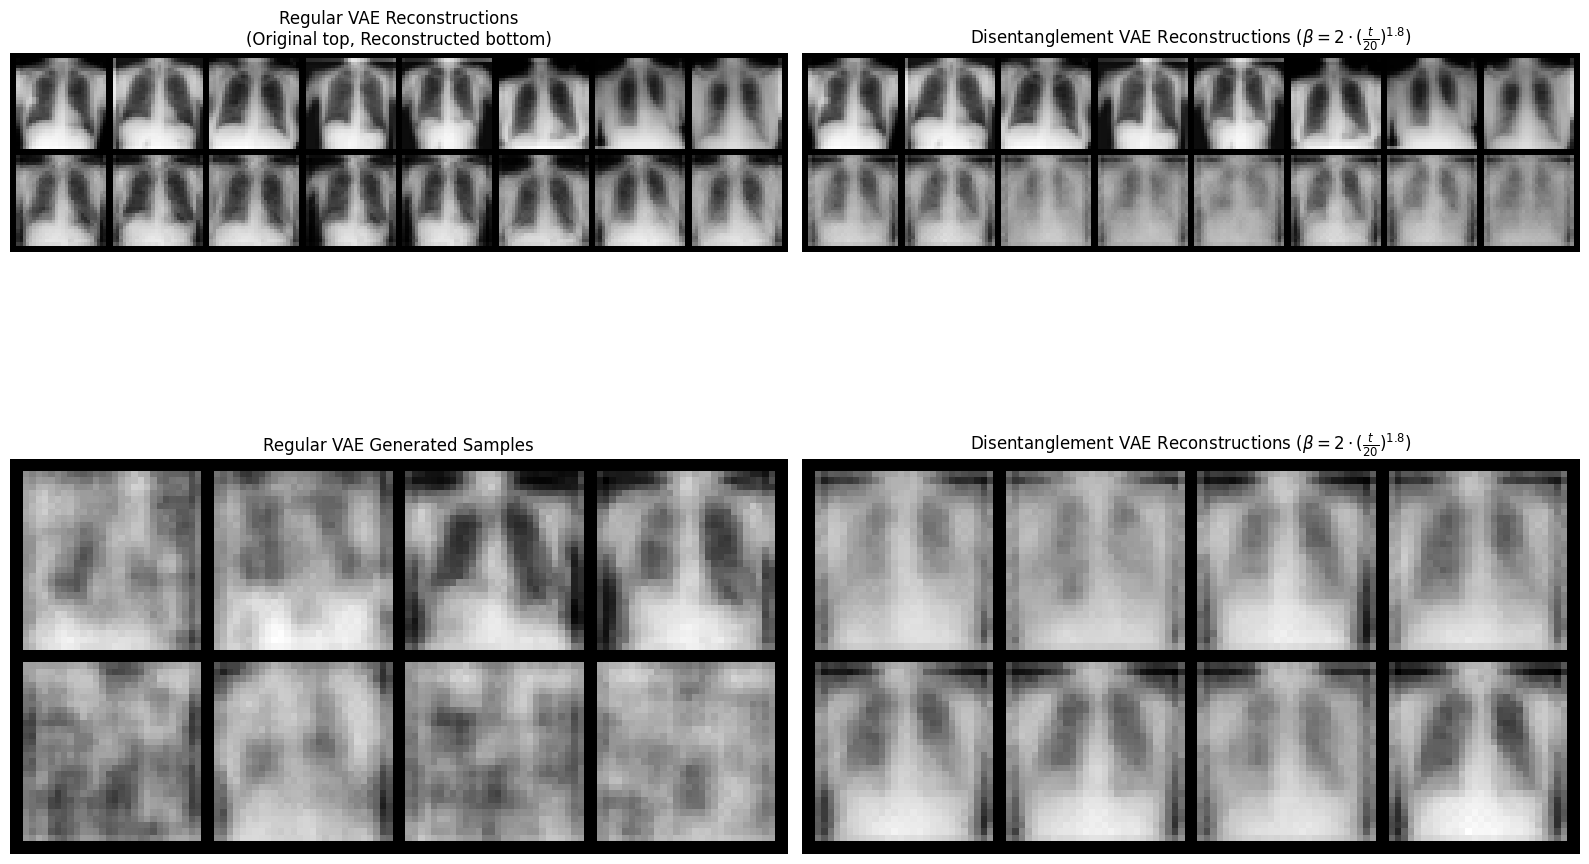

In [84]:
def compare_models_side_by_side(regular_model: VAE, disentanglement_model: VAE, 
                               test_loader: DataLoader, device: torch.device, 
                               num_samples: int = 8) -> None:
    """Compare regular and disentanglement models side by side."""
    regular_model.eval()
    disentanglement_model.eval()
    
    with torch.no_grad():
        # Get test batch
        test_data, _ = next(iter(test_loader))
        test_data = test_data[:num_samples].to(device)
        
        # Reconstruct with both models
        regular_recon, _, _ = regular_model(test_data)
        disentangled_recon, _, _ = disentanglement_model(test_data)
        
        # Generate samples with both models
        regular_samples = regular_model.generate(num_samples, device)
        disentangled_samples = disentanglement_model.generate(num_samples, device)
        
        # Create comparison grids
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Reconstruction comparison
        regular_comparison = torch.cat([test_data, regular_recon])
        regular_grid = make_grid(regular_comparison, nrow=num_samples, normalize=True, padding=2)
        
        disentangled_comparison = torch.cat([test_data, disentangled_recon])
        disentangled_grid = make_grid(disentangled_comparison, nrow=num_samples, normalize=True, padding=2)
        
        axes[0,0].imshow(regular_grid.permute(1, 2, 0).cpu())
        axes[0,0].set_title('Regular VAE Reconstructions\n(Original top, Reconstructed bottom)')
        axes[0,0].axis('off')
        
        axes[0,1].imshow(disentangled_grid.permute(1, 2, 0).cpu())
        axes[0, 1].set_title(r'Disentanglement VAE Reconstructions ($\beta = 2 \cdot (\frac{t}{20})^{1.8}$)')
        axes[0,1].axis('off')
        
        # Generated samples comparison
        regular_samples_grid = make_grid(regular_samples, nrow=4, normalize=True, padding=2)
        disentangled_samples_grid = make_grid(disentangled_samples, nrow=4, normalize=True, padding=2)
        
        axes[1,0].imshow(regular_samples_grid.permute(1, 2, 0).cpu())
        axes[1,0].set_title('Regular VAE Generated Samples')
        axes[1,0].axis('off')
        
        axes[1,1].imshow(disentangled_samples_grid.permute(1, 2, 0).cpu())
        axes[1, 1].set_title(r'Disentanglement VAE Reconstructions ($\beta = 2 \cdot (\frac{t}{20})^{1.8}$)')
        axes[1,1].axis('off')
        
        plt.tight_layout()
        plt.show()

# Compare models side by side
print("=" * 70)
print("SIDE-BY-SIDE MODEL COMPARISON")
print("=" * 70)
compare_models_side_by_side(model, disentanglement_model, test_loader, device)

In [81]:
# Save the trained models
regular_model_path = output_dir / 'vae_model.pth'
disentanglement_model_path = output_dir / 'vae_disentanglement_model.pth'

# Save regular model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'config': CONFIG,
    'dataset_info': dataset_info,
    'train_losses': train_losses,
    'test_losses': test_losses,
    'model_type': 'regular'
}, regular_model_path)

# Save disentanglement model
torch.save({
    'model_state_dict': disentanglement_model.state_dict(),
    'optimizer_state_dict': disentanglement_optimizer.state_dict(),
    'config': CONFIG,
    'dataset_info': dataset_info,
    'train_losses': disentanglement_losses,
    'beta_used': CONFIG['DISENTANGLEMENT_BETA'],
    'model_type': 'disentanglement'
}, disentanglement_model_path)

print(f"Regular model saved to: {regular_model_path}")
print(f"Disentanglement model saved to: {disentanglement_model_path}")
print(f"Final regular train loss: {train_losses[-1]['total_loss']:.4f}")
print(f"Final regular test loss: {test_losses[-1]['total_loss']:.4f}")
print(f"Final disentanglement train loss: {disentanglement_losses[-1]['total_loss']:.4f}")

# Compare the models
print(f"\nModel Comparison:")
print(f"Regular VAE final losses - Total: {train_losses[-1]['total_loss']:.4f}, "
      f"Recon: {train_losses[-1]['recon_loss']:.4f}, KL: {train_losses[-1]['kl_loss']:.4f}")
print(f"Disentanglement VAE final losses - Total: {disentanglement_losses[-1]['total_loss']:.4f}, "
      f"Recon: {disentanglement_losses[-1]['recon_loss']:.4f}, KL: {disentanglement_losses[-1]['kl_loss']:.4f}")
print(f"Disentanglement model used β={CONFIG['DISENTANGLEMENT_BETA']} (vs regular β≤{CONFIG['BETA_KL']})")

Regular model saved to: outputs/vae_model.pth
Disentanglement model saved to: outputs/vae_disentanglement_model.pth
Final regular train loss: 8.1971
Final regular test loss: 8.1873
Final disentanglement train loss: 13.2676

Model Comparison:
Regular VAE final losses - Total: 8.1971, Recon: 5.7092, KL: 24.8789
Disentanglement VAE final losses - Total: 13.2676, Recon: 12.7790, KL: 0.2679
Disentanglement model used β=1.31 (vs regular β≤1.0)


## 6. Summary: Regular VAE vs Disentanglement VAE

This notebook implements both regular VAE training and disentanglement training approaches, following the methodology from ConvolutionalVariationalEncoder:

### Key Features Implemented:

1. **Perceptual Loss**: Uses VGG-16 features for more perceptually meaningful reconstruction loss
2. **Modular Architecture**: Clean separation of encoder, decoder, and VAE components
3. **Dual Training Modes**:
   - **Regular VAE**: Uses β-annealing starting from 0 and gradually increasing to 1.0
   - **Disentanglement VAE**: Uses an exponential β ($\beta = 2 \cdot (t / 20)^{1.8}$) to be topped at 2. 

### Training Differences:

- **Regular Training**: β anneals from 0 to 1.0 over 200 epochs to balance reconstruction and KL terms
- **Disentanglement Training**: Exponential β ($\beta = 2 \cdot (t / 20)^{1.8}$) emphasizes KL divergence for better disentanglement

### Loss Function:
- Supports both perceptual loss (VGG features) and MSE loss
- KL divergence calculation matches ConvolutionalVariationalEncoder implementation
- Loss normalization follows the original approach

### Expected Outcomes:
- **Regular VAE**: Better reconstruction quality, potentially entangled representations
- **Disentanglement VAE**: More interpretable latent space, potentially lower reconstruction fidelity

The implementation maintains the modular structure while incorporating the advanced loss functions and training strategies from the ConvolutionalVariationalEncoder.